In [1]:
# import libraries
import numpy as py

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Python Requests Module
import requests

# JSON
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Beautifulsoup
from bs4 import BeautifulSoup

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.0.1               |             py_0         575 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1e             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                       

***
# Part 1
### Scrape the Wikipedia page for Toronto postal codes, boroughs and neighborhoods
### Transform the scraped data into a pandas dataframe
### Create the dataframe to have the following:
#### - three columns: PostalCode, Borough, and Neighborhood
#### - do not process Boroughs that are 'Not assigned'
#### - in cases where a postal code has more than one neighborhood, consolidate the neighborhoods in one row separated by commas
#### - for cells that have a Borough, but a Not assigned neighborhood, set the neighborhood to the Borough name
### In the last cell of the notebook, use the .shape method to print the number of rows in the dataframe
***

In [2]:
# Use Requests library to scrape the Wikipedia page https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M 
# in order to obtain the data that is in the table of postal codes 

# Syntax
# requests.methodname(params)
# Method
# get(url, params, args) - Sends a GET request to the specified url
# Returns
# Returns a Response Object with all the response data (content, encoding, status, etc)
#url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
url = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050"
response = requests.get(url)

# Print returned text - returned all html code on the page
#print(response.text)

In [3]:
# BeautifulSoup works with parsers to provide idiomatic ways of navigating, searching, and modifying the parse tree.
# Parser: lxml
# lxml is the most feature-rich and easy-to-use library for processing XML and HTML in the Python language
# To parse a document, pass it into the BeautifulSoup constructor.
soup = BeautifulSoup(response.content,'lxml')
#soup

In [4]:
# Find the first table tag
# Retrieve the contents of the table
table = soup.find_all('table')[0]
#table

In [5]:
# pandas.read_html(io, match='.+', flavor=None, header=None, index_col=None, skiprows=None, attrs=None, parse_dates=False, thousands=', ', encoding=None, decimal='.', converters=None, na_values=None, keep_default_na=True, displayed_only=True)
# Read HTML tables into a list of DataFrame objects
# Parameters
# io : str - a raw string containing HTML
# Returns
# A list of dataframes
df = pd.read_html(str(table))
#df

In [6]:
# Transform the list df into a dataframe
neighborhood=pd.DataFrame(df[0])
neighborhood.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [7]:
# remove rows where Borough is 'Not assigned'
df_neighborhood = neighborhood[neighborhood['Borough'] != 'Not assigned']

# reset index, because rows were dropped
# DataFrame.reset_index(self, level: Union[Hashable, Sequence[Hashable], NoneType] = None, drop: bool = False, inplace: bool = False, col_level: Hashable = 0, col_fill: Union[Hashable, NoneType] = '')
# Parameters
# drop : bool, default False - Do not try to insert index into dataframe columns. This resets the index to the default integer index.
# inplace : bool, default False - Modify the DataFrame in place (do not create a new object).
# Returns
# DataFrame with the new index or None if inplace=True
df_neighborhood.reset_index(drop=True, inplace=True)

df_neighborhood.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [8]:
# Replace 'Not assigned' in Neighbourhood column with value in corresponding 'Borough' column
df_neighborhood['Neighbourhood']=df_neighborhood['Neighbourhood'].replace('Not assigned', df_neighborhood['Borough'])
df_neighborhood.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [9]:
# In cases where a postal code has more than one neighborhood, consolidate the neighborhoods in one row separated by commas

# DataFrame.groupby(self, by=None, axis=0, level=None, as_index: bool = True, sort: bool = True, group_keys: bool = True, squeeze: bool = False, observed: bool = False)
# Group DataFrame using a mapper or by a Series of columns.
# A groupby operation involves some combination of splitting the object, applying a function, and combining the results. 
# This can be used to group large amounts of data and compute operations on these groups.
# Parameters
# by : mapping, function, label, or list of labels - Used to determine the groups for the groupby. 
# Returns
# DataFrameGroupBy - Returns a groupby object that contains information about the groups.
#
# DataFrame.sample(self: ~FrameOrSeries, n=None, frac=None, replace=False, weights=None, random_state=None, axis=None)
# Return a random sample of items from an axis of object. You can use random_state for reproducibility.
# Parameters
# frac : float, optional - Fraction of axis items to return. Cannot be used with n. 
# if frac=1, 100% of items are returned
# Returns
# Series or DataFrame - A new object of same type as caller containing n items randomly sampled from the caller object.
#
# Series.str.join(self, sep)
# Join lists contained as elements in the Series/Index with passed delimiter.
# If the elements of a Series are lists themselves, join the content of these lists using the delimiter passed to the function. 
# This function is an equivalent to str.join().
# Parameters
# sep : str - Delimiter to use between list entries.
# Returns
# Series/Index : object - The list entries concatenated by intervening occurrences of the delimiter.
df_neighborhood = df_neighborhood.groupby(['Postcode','Borough'])['Neighbourhood'].apply(list)
df_neighborhood = df_neighborhood.sample(frac=1).reset_index()
df_neighborhood['Neighbourhood']= df_neighborhood['Neighbourhood'].str.join(', ')
df_neighborhood.head()

,Postcode,Borough,Neighbourhood
0,M4L,East Toronto,"The Beaches West, India Bazaar"
1,M4G,East York,Leaside
2,M5K,Downtown Toronto,"Design Exchange, Toronto Dominion Centre"
3,M3A,North York,Parkwoods
4,M4R,Central Toronto,North Toronto West


In [10]:
# Rename the columns to conform with instructions

# DataFrame.rename(self, mapper=None, index=None, columns=None, axis=None, copy=True, inplace=False, level=None, errors='ignore')
# Alter axes labels.
# Parameters
# columns : dict-like or function - Alternative to specifying axis (mapper, axis=1 is equivalent to columns=mapper).
# inplace : bool, default False - Whether to return a new DataFrame. If True then value of copy is ignored.
df_neighborhood.rename(columns = {'Postcode':'PostalCode', 'Neighbourhood': 'Neighborhood'}, inplace = True) 
df_neighborhood.head()

,PostalCode,Borough,Neighborhood
0,M4L,East Toronto,"The Beaches West, India Bazaar"
1,M4G,East York,Leaside
2,M5K,Downtown Toronto,"Design Exchange, Toronto Dominion Centre"
3,M3A,North York,Parkwoods
4,M4R,Central Toronto,North Toronto West


In [11]:
df_neighborhood.shape

(103, 3)

***
# Part 2
##  Get the latitude and longitude coordinates for each neighborhood so that the Foursquare location data can be utilized
###  Download the csv file, http://cocl.us/Geospatial_data, which has the geographical coordinates of each postal code 
###  Upload the file to IBM Watson Studio notebook
###  Create a dataframe that has both the neighborhoods and the geographical coordinates
***

In [12]:
# The code was removed by Watson Studio for sharing.

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
# Find number of rows in geospatial coordinates dataframe
df_data_0.shape

(103, 3)

In [14]:
# Rename Postal Code column in dataframe from Geospatial_Coordinates.csv so it matches that in neighborhood dataframe
df_data_0.rename(columns = {'Postal Code':'PostalCode'}, inplace = True) 
df_data_0.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [15]:
# Merge the Neighborhood dataframe with the latitude and longitude dataframe
left = df_neighborhood
right = df_data_0
df_neighborhood_latlong = pd.merge(left, right, on='PostalCode')
df_neighborhood_latlong.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
1,M4G,East York,Leaside,43.709060,-79.363452
2,M5K,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576
3,M3A,North York,Parkwoods,43.753259,-79.329656
4,M4R,Central Toronto,North Toronto West,43.715383,-79.405678


In [16]:
# Get the number of rows in the new merged dataframe
df_neighborhood_latlong.shape

(103, 5)

***
# Part 3
##  Explore and cluster the neighborhoods in Toronto. 
##  NOTE: Only neighborhoods in Downtown Toronto are included. 
### Downtown Toronto was chosen for analysis because it is the main business district in Toronoto and has several neighborhoods. 
### Replicate the analysis done for the New York City data, Week 3
### Report my observations
### Generate maps to visualize the neighborhoods and how they cluster together
***

In [17]:
# Show all the boroughs in Toronto
df_neighborhood_latlong['Borough'].sort_values().unique()

array(['Central Toronto', 'Downtown Toronto', 'East Toronto', 'East York',
       'Etobicoke', 'Mississauga', 'North York', 'Scarborough',
       'West Toronto', 'York'], dtype=object)

In [18]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_neighborhood_latlong['Borough'].unique()),
        df_neighborhood_latlong.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


In [19]:
# Get the latitude and longitude of Toronto
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.653963, -79.387207.


In [20]:
# Given Toronto latitude and longitude, 
# create a map of Toronto with the neighborhoods superimposed on top
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_neighborhood_latlong['Latitude'], df_neighborhood_latlong['Longitude'], df_neighborhood_latlong['Borough'], df_neighborhood_latlong['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [21]:
# Find how many neighborhoods are in Downtown Toronto
 
a = df_neighborhood_latlong.apply(lambda x: True if x['Borough'] == 'Downtown Toronto' else False , axis=1)
number_of_rows = len(a[a == True].index)
print('Number of Rows in dataframe for Downtown Toronto : ', number_of_rows)

Number of Rows in dataframe for Downtown Toronto :  19


In [22]:
# Segment and cluster Downtown Toronto since it has the most neighborhoods

# Find all the neighborhoods for Downtown Toronto
df_downtown_toronto = df_neighborhood_latlong[df_neighborhood_latlong['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
df_downtown_toronto

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5K,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576
1,M6G,Downtown Toronto,Christie,43.669542,-79.422564
2,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568
5,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
6,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
7,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
8,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
9,M5T,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049


In [23]:
df_downtown_toronto.shape

(19, 5)

In [24]:
# Get the geographical coordinates of downtown Toronto
address = 'Downtown Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Downtown Toronot are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Downtown Toronot are 43.6541737, -79.38081164513409.


In [25]:
# create map of Downtown Toronto using latitude and longitude values
map_downtown_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_downtown_toronto['Latitude'], df_downtown_toronto['Longitude'], df_downtown_toronto['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_downtown_toronto)  
    
map_downtown_toronto

In [26]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: ER1UQOYZRIMU01DGS0SMX0YQRQJIVWSG3JBNM50ZUYODQEX4
CLIENT_SECRET:KS0JTIGYA2LG1OOXO030IZXVB5BQ2H53GQKGZQE3CKH5UA4W
ACCESS_TOKEN:ZZTIZKFYFXXR2JOPDF4P0HF51IALJYI1UKUA3U10JEXYEFVI


In [27]:
# Explore the first neighborhood in Downtown Toronto
# Get the name of the neighborhood
df_downtown_toronto.loc[0, 'Neighborhood']

'Design Exchange, Toronto Dominion Centre'

In [28]:
# Get the latitude and longitude of the neighborhood
neighborhood_latitude = df_downtown_toronto.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_downtown_toronto.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_downtown_toronto.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Design Exchange, Toronto Dominion Centre are 43.6471768, -79.38157640000001.


In [29]:
# Get the top 100 venues within 500 meters in the first neighborhood in downtown Toronto
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # meters

In [30]:
# Build the request url
url =  'https://api.foursquare.com/v2/venues/explore?             &client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?             &client_id=ER1UQOYZRIMU01DGS0SMX0YQRQJIVWSG3JBNM50ZUYODQEX4&client_secret=KS0JTIGYA2LG1OOXO030IZXVB5BQ2H53GQKGZQE3CKH5UA4W&v=20180605&ll=43.6471768,-79.38157640000001&radius=500&limit=100'

In [31]:
# Sent the GET request and look at the results
results = requests.get(url).json()
#results

In [32]:
# All the information is in the items key. 
# Borrow the get_category_type function from the Foursquare lab.

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [33]:
venues = results['response']['groups'][0]['items'] # result is a list

nearby_venues = json_normalize(venues) # flatten JSON
nearby_venues.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-501ae947e4b0d11883b910a7-0,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",501ae947e4b0d11883b910a7,199 Bay St,CA,Toronto,Canada,"at Commerce Court West, PATH Level",164,"[199 Bay St (at Commerce Court West, PATH Leve...","[{'label': 'display', 'lat': 43.64809974034856...",43.648100,-79.379989,NaN,M5L 1L5,ON,Equinox Bay Street,0,[],NaN
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ad4c05df964a52059f620e3-1,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",4ad4c05df964a52059f620e3,66 Wellington St West,CA,Toronto,Canada,at Bay Street,36,"[66 Wellington St West (at Bay Street), Toront...","[{'label': 'display', 'lat': 43.64745206618347...",43.647452,-79.381320,NaN,M5K 1H6,ON,Canoe,0,[],40552945
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-5a8f505eb6eedb5c284a78ad-2,"[{'id': '4bf58dd8d48988d11b941735', 'name': 'P...",5a8f505eb6eedb5c284a78ad,187 Bay St,CA,Toronto,Canada,Wellington St W,167,"[187 Bay St (Wellington St W), Toronto ON M5L ...","[{'label': 'display', 'lat': 43.64737470920577...",43.647375,-79.379515,NaN,M5L 1G5,ON,Walrus Pub & Beer Hall,0,[],NaN
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-59cd51c71b0ea516e9e7b3aa-3,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",59cd51c71b0ea516e9e7b3aa,100 King St W,CA,Toronto,Canada,Bay St,191,"[100 King St W (Bay St), Toronto ON M5X, Canada]","[{'label': 'display', 'lat': 43.64883539124589...",43.648835,-79.380936,NaN,M5X,ON,Pilot Coffee Roasters,0,[],NaN
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ad4c05bf964a520a7f520e3-4,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",4ad4c05bf964a520a7f520e3,100 Front St W,CA,Toronto,Canada,btwn York St & Bay St,192,"[100 Front St W (btwn York St & Bay St), Toron...","[{'label': 'display', 'lat': 43.64544914616651...",43.645449,-79.381508,NaN,M5J 1E3,ON,The Fairmont Royal York,0,[],NaN


In [34]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Equinox Bay Street,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",43.648100,-79.379989
1,Canoe,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.647452,-79.381320
2,Walrus Pub & Beer Hall,"[{'id': '4bf58dd8d48988d11b941735', 'name': 'P...",43.647375,-79.379515
3,Pilot Coffee Roasters,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.648835,-79.380936
4,The Fairmont Royal York,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",43.645449,-79.381508


In [35]:
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Equinox Bay Street,Gym,43.648100,-79.379989
1,Canoe,Restaurant,43.647452,-79.381320
2,Walrus Pub & Beer Hall,Pub,43.647375,-79.379515
3,Pilot Coffee Roasters,Coffee Shop,43.648835,-79.380936
4,The Fairmont Royal York,Hotel,43.645449,-79.381508


In [36]:
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(25)

,name,categories,lat,lng
0,Equinox Bay Street,Gym,43.648100,-79.379989
1,Canoe,Restaurant,43.647452,-79.381320
2,Walrus Pub & Beer Hall,Pub,43.647375,-79.379515
3,Pilot Coffee Roasters,Coffee Shop,43.648835,-79.380936
4,The Fairmont Royal York,Hotel,43.645449,-79.381508
5,Starbucks,Coffee Shop,43.646731,-79.383951
6,DAVIDsTEA,Tea Room,43.646506,-79.380145
7,WVRST,Beer Bar,43.644968,-79.381376
8,Maman,Café,43.648309,-79.382253
9,Mos Mos Coffee,Café,43.648159,-79.378745


In [37]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))


100 venues were returned by Foursquare.


In [38]:
# Function to repeat the same process for all the neighborhoods in Downtown Toronto
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
downtown_toronto_venues = getNearbyVenues(names=df_downtown_toronto['Neighborhood'],
                                   latitudes=df_downtown_toronto['Latitude'],
                                   longitudes=df_downtown_toronto['Longitude']
                                  )

Design Exchange, Toronto Dominion Centre
Christie
First Canadian Place, Underground city
St. James Town
Adelaide, King, Richmond
Rosedale
Harbourfront
Ryerson, Garden District
Berczy Park
Chinatown, Grange Park, Kensington Market
Stn A PO Boxes 25 The Esplanade
Harbourfront East, Toronto Islands, Union Station
Cabbagetown, St. James Town
Queen's Park
Church and Wellesley
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Central Bay Street
Commerce Court, Victoria Hotel
Harbord, University of Toronto


In [40]:
print(downtown_toronto_venues.shape)
downtown_toronto_venues.head()

(1315, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,Equinox Bay Street,43.648100,-79.379989,Gym
1,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,Canoe,43.647452,-79.381320,Restaurant
2,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,Walrus Pub & Beer Hall,43.647375,-79.379515,Pub
3,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,Pilot Coffee Roasters,43.648835,-79.380936,Coffee Shop
4,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,The Fairmont Royal York,43.645449,-79.381508,Hotel


In [41]:
# Check how many venues were returned for each neighborhood
downtown_toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,56,56,56,56,56,56
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",16,16,16,16,16,16
"Cabbagetown, St. James Town",46,46,46,46,46,46
Central Bay Street,83,83,83,83,83,83
"Chinatown, Grange Park, Kensington Market",87,87,87,87,87,87
Christie,18,18,18,18,18,18
Church and Wellesley,87,87,87,87,87,87
"Commerce Court, Victoria Hotel",100,100,100,100,100,100


In [42]:
# Find how many unique categories can be curated from all the returned venues
print('There are {} unique categories.'.format(len(downtown_toronto_venues['Venue Category'].unique())))

There are 210 unique categories.


In [43]:
# Analyze each neighborhood
 
# Returns DataFrame downtown_toronto_onehot with dummy-coded data for Venue Category column only
downtown_toronto_onehot = pd.get_dummies(downtown_toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# performed onehot coding on neighborhood - drop the column
downtown_toronto_onehot.drop(['Neighborhood'], axis=1)

# add neighborhood column to dataframe - Inserts the column alphabetically
downtown_toronto_onehot['Neighborhood'] = downtown_toronto_venues['Neighborhood']
downtown_toronto_onehot.head()

,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Design Exchange, Toronto Dominion Centre",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Design Exchange, Toronto Dominion Centre",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [44]:
# find the position of the 'Neighborhood' column
column_position = downtown_toronto_onehot.columns.get_loc('Neighborhood')
#print("position: ",column_position )     

In [45]:

# move neighborhood column to the first column
# downtown_toronto_onehot.columns[position] is the Neighborhood column
# concatenate the Neighborhood column with the list of columns before it and after it
fixed_columns = [downtown_toronto_onehot.columns[column_position]] + list(downtown_toronto_onehot.columns[:column_position]) + list(downtown_toronto_onehot.columns[column_position + 1:])


# save the dataframe with the new arrangement of columns
downtown_toronto_onehot = downtown_toronto_onehot[fixed_columns]
       
downtown_toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Design Exchange, Toronto Dominion Centre",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Design Exchange, Toronto Dominion Centre",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Design Exchange, Toronto Dominion Centre",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [46]:
# Get size of dataframe
downtown_toronto_onehot.shape

(1315, 210)

In [47]:
# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
downtown_toronto_grouped = downtown_toronto_onehot.groupby('Neighborhood').mean().reset_index()
downtown_toronto_grouped

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.020000,0.000000,0.00,0.010000,0.010000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.030000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.020000,0.000000,0.01,0.020000,0.000000,0.000000,0.01,0.010000,0.010000,0.000000,0.000000,0.040000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.070000,0.000000,0.00000,0.000000,0.00,0.01,0.000000,0.000000,0.020000,0.020000,0.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.020000,0.000000,0.000000,0.01,0.00,0.010000,0.01,0.000000,0.010000,0.000000,0.020000,0.010000,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.020000,0.000

In [48]:
# Confirm the dataframe size
downtown_toronto_grouped.shape

(19, 210)

In [49]:
# print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in downtown_toronto_grouped['Neighborhood']:
    
    # print the subtitle
    print("----"+hood+"----")
    
    # if the neighborhood matches the current neighborhood, save it in temp, transposed, and reset the index
    temp = downtown_toronto_grouped[downtown_toronto_grouped['Neighborhood'] == hood].T.reset_index()
    
    # add columns venue and freq to temp
    temp.columns = ['venue','freq']
    
    # assign all venues and frequencies to the appropriate columns
    temp = temp.iloc[1:]
    
    # set frequency to float and round to two decimal places
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    
    # sort venues by their frequencies in descending order
    # print only the first 5 venues
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
             venue  freq
0      Coffee Shop  0.07
1       Restaurant  0.05
2  Thai Restaurant  0.04
3             Café  0.04
4              Bar  0.03


----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1  Seafood Restaurant  0.04
2              Bakery  0.04
3          Restaurant  0.04
4      Farmers Market  0.04


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0    Airport Lounge  0.12
1   Airport Service  0.12
2  Airport Terminal  0.12
3          Boutique  0.06
4       Coffee Shop  0.06


----Cabbagetown, St. James Town----
         venue  freq
0  Coffee Shop  0.07
1   Restaurant  0.04
2         Café  0.04
3    Pet Store  0.04
4     Pharmacy  0.04


----Central Bay Street----
                 venue  freq
0          Coffee Shop  0.17
1   Italian Restaurant  0.05
2       Ice Cream Shop  0.04
3  Japanese Restaurant  0.04
4         Burger

In [50]:
# Put the top venues into a pandas dataframe
# First, write a function to sort the venues in descending order.
# given each row in a neighborhood, sort by most common venue for num_top_venues
def return_most_common_venues(row, num_top_venues):
    
    # select the venue and frequency from the row
    row_categories = row.iloc[1:]
    
    # sort the frequencies in descending order
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    # return only the top venues
    return row_categories_sorted.index.values[0:num_top_venues]

In [51]:
# Create the new dataframe and display the top 10 venues for each neighborhood.
import numpy as np
num_top_venues = 10

# add 'st', or 'nd', or 'rd' to venue column name - 1st, 2nd, 3rd
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
# First column is Neighborhood
columns = ['Neighborhood']

# Add columns for 1st through number of top venues
# NumPy arange() is one of the array creation routines based on numerical ranges. 
# It creates an instance of ndarray with evenly spaced values and returns the reference to it.
for ind in np.arange(num_top_venues):
    try:
        # When ind is 0, column is 1st. When ind is 1, column is 2nd. When ind is 2, column is 3rd.
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        # When ind is 3 to num_top_venues, column is ind+1th.
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe with the columns just named
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)

# set the new dataframe Neighborhood column to that in the manhattan_grouped dataframe
neighborhoods_venues_sorted['Neighborhood'] = downtown_toronto_grouped['Neighborhood']

# for all rows in the downtown_toronto_grouped dataframe
# neighborhoods_venues_sorted where rows match ind, and columns 1 to the end is equal to: 
# call return_most_common_venues function with the row equal to ind, and num_top_venues 
for ind in np.arange(downtown_toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(downtown_toronto_grouped.iloc[ind, :], num_top_venues)

# print the new dataframe
neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Restaurant,Café,Thai Restaurant,Steakhouse,Bar,Cosmetics Shop,Bookstore,Pizza Place,Breakfast Spot
1,Berczy Park,Coffee Shop,Farmers Market,Restaurant,Cheese Shop,Beer Bar,Seafood Restaurant,Bakery,Cocktail Bar,Café,Greek Restaurant
2,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Service,Airport Terminal,Plane,Harbor / Marina,Sculpture Garden,Boat or Ferry,Rental Car Location,Coffee Shop,Boutique
3,"Cabbagetown, St. James Town",Coffee Shop,Bakery,Park,Restaurant,Italian Restaurant,Café,Pizza Place,Pharmacy,Pet Store,Pub
4,Central Bay Street,Coffee Shop,Italian Restaurant,Ice Cream Shop,Sandwich Place,Japanese Restaurant,Burger Joint,Juice Bar,Chinese Restaurant,Restaurant,Department Store


In [53]:
# Find the best k - iterate over 2 to 10 clusters
kMax = 10
cost= [] 

for k in range(2,kMax+1):
    kmeans = KMeans(n_clusters = k, random_state=0).fit(downtown_toronto_grouped_clustering) 
    # calculates squared error for the clustered points 
    cost.append(kmeans.inertia_)

In [54]:
value_of_k = [2,3,4,5,6,7,8,9,10]

df_cost = pd.DataFrame(cost,value_of_k)
df_cost

,0
2,0.424595
3,0.331952
4,0.242397
5,0.199582
6,0.162752
7,0.140235
8,0.119287
9,0.100439
10,0.081066


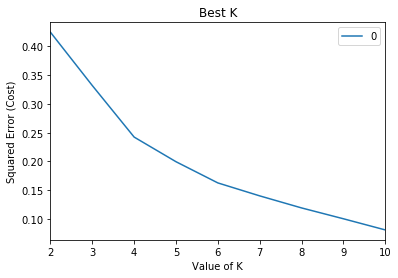

In [58]:
df_cost.plot()

plt.title('Best K')
plt.ylabel('Squared Error (Cost)')
plt.xlabel('Value of K')

plt.show()

### From the line plot above, the best k is 4

In [59]:
# Best k is 4
# Cluster Neighborhoods - Run k-means to cluster the neighborhood into 5 clusters.
# set number of clusters
kclusters = 4

# drop the Neighborhood column
downtown_toronto_grouped_clustering = downtown_toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(downtown_toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 2, 1, 1, 1, 3, 1, 1, 1], dtype=int32)

In [60]:
# Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# manhattan_data has latitude and longitude
downtown_toronto_merged = df_downtown_toronto

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
downtown_toronto_merged = downtown_toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

downtown_toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5K,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,1,Coffee Shop,Hotel,Café,Restaurant,Seafood Restaurant,Japanese Restaurant,Italian Restaurant,Bar,Gastropub,American Restaurant
1,M6G,Downtown Toronto,Christie,43.669542,-79.422564,3,Grocery Store,Café,Park,Coffee Shop,Candy Store,Restaurant,Italian Restaurant,Diner,Baby Store,Athletics & Sports
2,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,1,Coffee Shop,Café,Restaurant,Gym,Steakhouse,Japanese Restaurant,Hotel,Gastropub,American Restaurant,Seafood Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,Restaurant,Italian Restaurant,Hotel,Diner,Breakfast Spot,Clothing Store,Bakery,Cosmetics Shop
4,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,1,Coffee Shop,Restaurant,Café,Thai Restaurant,Steakhouse,Bar,Cosmetics Shop,Bookstore,Pizza Place,Breakfast Spot


In [61]:
# Visualize the resulting clusters
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_toronto_merged['Latitude'], downtown_toronto_merged['Longitude'], downtown_toronto_merged['Neighborhood'], downtown_toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

In [62]:
# Examine Clusters
# Examine each cluster and determine the discriminating venue categories that distinguish each cluster. 
# Based on the defining categories, assign a name to each cluster.

# Cluster 1 - Young ethnic families in suburban residential area  
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 0, downtown_toronto_merged.columns[[1] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Downtown Toronto,0,Park,Playground,Trail,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


In [63]:
# Cluster 2 - Business and tourist oriented with multi-ethnic restaurants
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 1, downtown_toronto_merged.columns[[1] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,1,Coffee Shop,Hotel,Café,Restaurant,Seafood Restaurant,Japanese Restaurant,Italian Restaurant,Bar,Gastropub,American Restaurant
2,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Gym,Steakhouse,Japanese Restaurant,Hotel,Gastropub,American Restaurant,Seafood Restaurant
3,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Italian Restaurant,Hotel,Diner,Breakfast Spot,Clothing Store,Bakery,Cosmetics Shop
4,Downtown Toronto,1,Coffee Shop,Restaurant,Café,Thai Restaurant,Steakhouse,Bar,Cosmetics Shop,Bookstore,Pizza Place,Breakfast Spot
6,Downtown Toronto,1,Coffee Shop,Bakery,Pub,Park,Theater,Mexican Restaurant,Café,Beer Store,Breakfast Spot,Restaurant
7,Downtown Toronto,1,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Japanese Restaurant,Cosmetics Shop,Café,Ramen Restaurant,Diner,Pizza Place,Bookstore
8,Downtown Toronto,1,Coffee Shop,Farmers Market,Restaurant,Cheese Shop,Beer Bar,Seafood Restaurant,Bakery,Cocktail Bar,Café,Greek Restaurant
9,Downtown Toronto,1,Bar,Vietnamese Restaurant,Café,Coffee Shop,Vegetarian / Vegan Restaurant,Bakery,Mexican Restaurant,Dumpling Restaurant,Comfort Food Restaurant,Cocktail Bar
10,Downtown Toronto,1,Coffee Shop,Restaurant,Café,Seafood Restaurant,Beer Bar,Hotel,Japanese Restaurant,Gym,Creperie,Park
11,Downtown Toronto,1,Coffee Shop,Aquarium,Italian Restaurant,Hotel,Café,Restaurant,Sporting Goods Shop,Fried Chicken Joint,Brewery,Scenic Lookout


In [64]:
# Cluster 3 - Airport and leisure day trip oriented
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 2, downtown_toronto_merged.columns[[1] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Downtown Toronto,2,Airport Lounge,Airport Service,Airport Terminal,Plane,Harbor / Marina,Sculpture Garden,Boat or Ferry,Rental Car Location,Coffee Shop,Boutique


In [65]:
# Cluster 4 Residential area for young families
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 3, downtown_toronto_merged.columns[[1] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Downtown Toronto,3,Grocery Store,Café,Park,Coffee Shop,Candy Store,Restaurant,Italian Restaurant,Diner,Baby Store,Athletics & Sports
